# Method 1 - Rest Ideas After 20

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Calculate Market Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 20].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

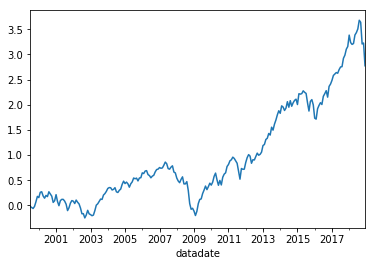

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.180963
2000-12-31   -0.073563
2001-12-31    0.003130
2002-12-31   -0.238937
2003-12-31    0.532871
2004-12-31    0.158071
2005-12-31    0.046593
2006-12-31    0.109854
2007-12-31   -0.043567
2008-12-31   -0.426296
2009-12-31    0.527310
2010-12-31    0.229476
2011-12-31   -0.029723
2012-12-31    0.195989
2013-12-31    0.399135
2014-12-31    0.080045
2015-12-31   -0.036372
2016-12-31    0.137356
2017-12-31    0.219059
2018-12-31   -0.092208
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1994.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.22e-176
Time:                        17:30:42   Log-Likelihood:                 772.63
No. Observations:                 234   AIC:                            -1535.
Df Residuals:                     229   BIC:                            -1518.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.409      0.000       0.001       0.004
mktrf          1.0275      0.017     61.178      0.000       0.994       1.061
me             0.2758      0.020     14.116      0.000       0.237       0.314
ia             0.0416      0.030      1.402      0.162      -0.017       0.100
roe           -0.2326      0.025     -9.151      0.000      -0.283      -0.182
==============================================================================
Omnibus:                       63.536   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.659
Skew:                           0.981   Prob(JB):                     2.31e-65
Kurtosis:                       8.165   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1336.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.12e-157
Time:                        17:30:42   Log-Likelihood:                 772.63
No. Observations:                 234   AIC:                            -1535.
Df Residuals:                     229   BIC:                            -1518.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.238      0.001       0.001       0.004
mktrf          1.0275      0.020     51.440      0.000       0.988       1.067
me             0.2758      0.035      7.910      0.000       0.207       0.344
ia             0.0416      0.051      0.823      0.411      -0.058       0.141
roe           -0.2326      0.042     -5.504      0.000      -0.315      -0.150
==============================================================================
Omnibus:                       63.536   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.659
Skew:                           0.981   Prob(JB):                     2.31e-65
Kurtosis:                       8.165   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1494.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.44e-163
Time:                        17:30:42   Log-Likelihood:                 772.63
No. Observations:                 234   AIC:                            -1535.
Df Residuals:                     229   BIC:                            -1518.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.896      0.004       0.001       0.005
mktrf          1.0275      0.020     51.407      0.000       0.988       1.067
me             0.2758      0.035      7.786      0.000       0.206       0.345
ia             0.0416      0.042      0.988      0.323      -0.041       0.124
roe           -0.2326      0.044     -5.272      0.000      -0.319      -0.146
==============================================================================
Omnibus:                       63.536   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.659
Skew:                           0.981   Prob(JB):                     2.31e-65
Kurtosis:                       8.165   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1284.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.12e-165
Time:                        17:30:42   Log-Likelihood:                 748.53
No. Observations:                 234   AIC:                            -1485.
Df Residuals:                     228   BIC:                            -1464.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.939      0.004       0.001       0.003
mktrf          1.0719      0.019     57.338      0.000       1.035       1.109
smb            0.3256      0.025     13.201      0.000       0.277       0.374
hml            0.0481      0.029      1.652      0.100      -0.009       0.105
rmw           -0.1356      0.033     -4.123      0.000      -0.200      -0.071
cma            0.0070      0.042      0.167      0.867      -0.075       0.089
==============================================================================
Omnibus:                       92.463   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.090
Skew:                           1.465   Prob(JB):                    6.94e-109
Kurtosis:                       9.519   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1245.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.82e-163
Time:                        17:30:42   Log-Likelihood:                 748.53
No. Observations:                 234   AIC:                            -1485.
Df Residuals:                     228   BIC:                            -1464.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.413      0.016       0.000       0.004
mktrf          1.0719      0.016     68.257      0.000       1.041       1.103
smb            0.3256      0.036      9.010      0.000       0.255       0.396
hml            0.0481      0.053      0.906      0.365      -0.056       0.152
rmw           -0.1356      0.047     -2.914      0.004      -0.227      -0.044
cma            0.0070      0.068      0.103      0.918      -0.125       0.139
==============================================================================
Omnibus:                       92.463   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.090
Skew:                           1.465   Prob(JB):                    6.94e-109
Kurtosis:                       9.519   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1456.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.68e-171
Time:                        17:30:42   Log-Likelihood:                 748.53
No. Observations:                 234   AIC:                            -1485.
Df Residuals:                     228   BIC:                            -1464.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.094      0.036       0.000       0.004
mktrf          1.0719      0.016     69.058      0.000       1.041       1.102
smb            0.3256      0.030     10.892      0.000       0.267       0.384
hml            0.0481      0.048      1.006      0.314      -0.046       0.142
rmw           -0.1356      0.053     -2.581      0.010      -0.239      -0.033
cma            0.0070      0.068      0.103      0.918      -0.126       0.140
==============================================================================
Omnibus:                       92.463   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.090
Skew:                           1.465   Prob(JB):                    6.94e-109
Kurtosis:                       9.519   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2075.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.49e-178
Time:                        17:30:42   Log-Likelihood:                 777.13
No. Observations:                 234   AIC:                            -1544.
Df Residuals:                     229   BIC:                            -1527.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.661      0.000       0.001       0.003
mktrf          1.0460      0.015     68.960      0.000       1.016       1.076
smb            0.3951      0.019     20.866      0.000       0.358       0.432
hml            0.0466      0.019      2.477      0.014       0.010       0.084
umd           -0.1234      0.012     -9.998      0.000      -0.148      -0.099
==============================================================================
Omnibus:                       24.193   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.021
Skew:                           0.398   Prob(JB):                     2.80e-15
Kurtosis:                       5.498   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1680.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.19e-168
Time:                        17:30:42   Log-Likelihood:                 777.13
No. Observations:                 234   AIC:                            -1544.
Df Residuals:                     229   BIC:                            -1527.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.541      0.011       0.000       0.004
mktrf          1.0460      0.017     60.922      0.000       1.012       1.080
smb            0.3951      0.023     17.253      0.000       0.350       0.440
hml            0.0466      0.040      1.155      0.248      -0.033       0.126
umd           -0.1234      0.020     -6.303      0.000      -0.162      -0.085
==============================================================================
Omnibus:                       24.193   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.021
Skew:                           0.398   Prob(JB):                     2.80e-15
Kurtosis:                       5.498   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1863.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.41e-173
Time:                        17:30:42   Log-Likelihood:                 777.13
No. Observations:                 234   AIC:                            -1544.
Df Residuals:                     229   BIC:                            -1527.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.187      0.029       0.000       0.004
mktrf          1.0460      0.015     69.432      0.000       1.016       1.076
smb            0.3951      0.021     18.729      0.000       0.354       0.436
hml            0.0466      0.041      1.140      0.254      -0.033       0.127
umd           -0.1234      0.018     -6.966      0.000      -0.158      -0.089
==============================================================================
Omnibus:                       24.193   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.021
Skew:                           0.398   Prob(JB):                     2.80e-15
Kurtosis:                       5.498   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     853.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.83e-84
Time:                        17:30:42   Log-Likelihood:                 371.93
No. Observations:                 120   AIC:                            -733.9
Df Residuals:                     115   BIC:                            -719.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      3.929      0.000       0.002       0.006
mktrf          1.0174      0.029     35.429      0.000       0.961       1.074
me             0.2409      0.028      8.493      0.000       0.185       0.297
ia             0.0716      0.044      1.612      0.110      -0.016       0.160
roe           -0.2670      0.039     -6.793      0.000      -0.345      -0.189
==============================================================================
Omnibus:                       26.948   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.565
Skew:                           0.877   Prob(JB):                     7.05e-14
Kurtosis:                       6.006   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     872.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.43e-85
Time:                        17:30:42   Log-Likelihood:                 371.93
No. Observations:                 120   AIC:                            -733.9
Df Residuals:                     115   BIC:                            -719.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      2.841      0.004       0.001       0.007
mktrf          1.0174      0.029     35.098      0.000       0.961       1.074
me             0.2409      0.040      6.091      0.000       0.163       0.318
ia             0.0716      0.065      1.108      0.268      -0.055       0.198
roe           -0.2670      0.051     -5.224      0.000      -0.367      -0.167
==============================================================================
Omnibus:                       26.948   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.565
Skew:                           0.877   Prob(JB):                     7.05e-14
Kurtosis:                       6.006   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1155.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.35e-92
Time:                        17:30:42   Log-Likelihood:                 371.93
No. Observations:                 120   AIC:                            -733.9
Df Residuals:                     115   BIC:                            -719.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.448      0.014       0.001       0.008
mktrf          1.0174      0.028     36.632      0.000       0.963       1.072
me             0.2409      0.042      5.738      0.000       0.159       0.323
ia             0.0716      0.053      1.350      0.177      -0.032       0.176
roe           -0.2670      0.052     -5.118      0.000      -0.369      -0.165
==============================================================================
Omnibus:                       26.948   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.565
Skew:                           0.877   Prob(JB):                     7.05e-14
Kurtosis:                       6.006   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     535.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.23e-77
Time:                        17:30:42   Log-Likelihood:                 358.36
No. Observations:                 120   AIC:                            -704.7
Df Residuals:                     114   BIC:                            -688.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.183      0.002       0.001       0.006
mktrf          1.1232      0.034     32.982      0.000       1.056       1.191
smb            0.3199      0.039      8.295      0.000       0.244       0.396
hml            0.0153      0.047      0.325      0.746      -0.078       0.109
rmw           -0.0967      0.056     -1.734      0.086      -0.207       0.014
cma            0.0672      0.061      1.100      0.274      -0.054       0.188
==============================================================================
Omnibus:                       38.469   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.367
Skew:                           1.154   Prob(JB):                     3.98e-25
Kurtosis:                       7.141   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     700.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.33e-84
Time:                        17:30:42   Log-Likelihood:                 358.36
No. Observations:                 120   AIC:                            -704.7
Df Residuals:                     114   BIC:                            -688.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      2.682      0.007       0.001       0.007
mktrf          1.1232      0.025     45.224      0.000       1.075       1.172
smb            0.3199      0.050      6.340      0.000       0.221       0.419
hml            0.0153      0.077      0.198      0.843      -0.136       0.167
rmw           -0.0967      0.061     -1.576      0.115      -0.217       0.024
cma            0.0672      0.081      0.827      0.408      -0.092       0.226
==============================================================================
Omnibus:                       38.469   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.367
Skew:                           1.154   Prob(JB):                     3.98e-25
Kurtosis:                       7.141   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1229.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.28e-97
Time:                        17:30:42   Log-Likelihood:                 358.36
No. Observations:                 120   AIC:                            -704.7
Df Residuals:                     114   BIC:                            -688.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.315      0.021       0.001       0.007
mktrf          1.1232      0.020     55.869      0.000       1.084       1.163
smb            0.3199      0.042      7.577      0.000       0.237       0.403
hml            0.0153      0.071      0.216      0.829      -0.124       0.155
rmw           -0.0967      0.066     -1.469      0.142      -0.226       0.032
cma            0.0672      0.080      0.837      0.403      -0.090       0.224
==============================================================================
Omnibus:                       38.469   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.367
Skew:                           1.154   Prob(JB):                     3.98e-25
Kurtosis:                       7.141   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     953.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.70e-87
Time:                        17:30:42   Log-Likelihood:                 378.41
No. Observations:                 120   AIC:                            -746.8
Df Residuals:                     115   BIC:                            -732.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      4.060      0.000       0.002       0.006
mktrf          1.0561      0.024     44.061      0.000       1.009       1.104
smb            0.3982      0.027     14.590      0.000       0.344       0.452
hml            0.0559      0.027      2.044      0.043       0.002       0.110
umd           -0.1327      0.017     -7.874      0.000      -0.166      -0.099
==============================================================================
Omnibus:                        7.170   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               11.504
Skew:                           0.189   Prob(JB):                      0.00318
Kurtosis:                       4.469   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     921.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.58e-86
Time:                        17:30:43   Log-Likelihood:                 378.41
No. Observations:                 120   AIC:                            -746.8
Df Residuals:                     115   BIC:                            -732.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.148      0.002       0.002       0.007
mktrf          1.0561      0.026     40.580      0.000       1.005       1.107
smb            0.3982      0.030     13.094      0.000       0.339       0.458
hml            0.0559      0.057      0.988      0.323      -0.055       0.167
umd           -0.1327      0.022     -6.099      0.000      -0.175      -0.090
==============================================================================
Omnibus:                        7.170   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               11.504
Skew:                           0.189   Prob(JB):                      0.00318
Kurtosis:                       4.469   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     993.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.75e-88
Time:                        17:30:43   Log-Likelihood:                 378.41
No. Observations:                 120   AIC:                            -746.8
Df Residuals:                     115   BIC:                            -732.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      2.701      0.007       0.001       0.007
mktrf          1.0561      0.023     46.662      0.000       1.012       1.101
smb            0.3982      0.031     12.953      0.000       0.338       0.458
hml            0.0559      0.059      0.949      0.343      -0.060       0.171
umd           -0.1327      0.019     -6.834      0.000      -0.171      -0.095
==============================================================================
Omnibus:                        7.170   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               11.504
Skew:                           0.189   Prob(JB):                      0.00318
Kurtosis:                       4.469   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1878.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.62e-99
Time:                        17:30:43   Log-Likelihood:                 435.84
No. Observations:                 114   AIC:                            -861.7
Df Residuals:                     109   BIC:                            -848.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.468      0.015       0.000       0.002
mktrf          1.0318      0.016     64.880      0.000       1.000       1.063
me             0.3504      0.025     14.269      0.000       0.302       0.399
ia            -0.0455      0.034     -1.337      0.184      -0.113       0.022
roe           -0.1903      0.030     -6.359      0.000      -0.250      -0.131
==============================================================================
Omnibus:                        1.723   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.389
Skew:                          -0.267   Prob(JB):                        0.499
Kurtosis:                       3.088   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     3983.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.96e-117
Time:                        17:30:43   Log-Likelihood:                 435.84
No. Observations:                 114   AIC:                            -861.7
Df Residuals:                     109   BIC:                            -848.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      2.857      0.004       0.000       0.002
mktrf          1.0318      0.013     76.431      0.000       1.005       1.058
me             0.3504      0.021     16.975      0.000       0.310       0.391
ia            -0.0455      0.034     -1.331      0.183      -0.113       0.021
roe           -0.1903      0.021     -8.882      0.000      -0.232      -0.148
==============================================================================
Omnibus:                        1.723   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.389
Skew:                          -0.267   Prob(JB):                        0.499
Kurtosis:                       3.088   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     5965.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.24e-126
Time:                        17:30:43   Log-Likelihood:                 435.84
No. Observations:                 114   AIC:                            -861.7
Df Residuals:                     109   BIC:                            -848.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.385      0.001       0.001       0.002
mktrf          1.0318      0.013     81.991      0.000       1.007       1.056
me             0.3504      0.018     19.301      0.000       0.315       0.386
ia            -0.0455      0.038     -1.208      0.227      -0.119       0.028
roe           -0.1903      0.017    -10.978      0.000      -0.224      -0.156
==============================================================================
Omnibus:                        1.723   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.389
Skew:                          -0.267   Prob(JB):                        0.499
Kurtosis:                       3.088   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1614.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-99
Time:                        17:30:43   Log-Likelihood:                 440.39
No. Observations:                 114   AIC:                            -868.8
Df Residuals:                     108   BIC:                            -852.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.650      0.517      -0.001       0.001
mktrf          1.0421      0.015     71.184      0.000       1.013       1.071
smb            0.3260      0.024     13.717      0.000       0.279       0.373
hml            0.0565      0.030      1.863      0.065      -0.004       0.117
rmw           -0.2207      0.037     -5.946      0.000      -0.294      -0.147
cma           -0.1035      0.047     -2.196      0.030      -0.197      -0.010
==============================================================================
Omnibus:                        1.336   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                0.859
Skew:                          -0.156   Prob(JB):                        0.651
Kurtosis:                       3.289   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2216.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.50e-107
Time:                        17:30:43   Log-Likelihood:                 440.39
No. Observations:                 114   AIC:                            -868.8
Df Residuals:                     108   BIC:                            -852.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.634      0.526      -0.001       0.001
mktrf          1.0421      0.012     89.028      0.000       1.019       1.065
smb            0.3260      0.021     15.738      0.000       0.285       0.367
hml            0.0565      0.038      1.469      0.142      -0.019       0.132
rmw           -0.2207      0.034     -6.448      0.000      -0.288      -0.154
cma           -0.1035      0.038     -2.713      0.007      -0.178      -0.029
==============================================================================
Omnibus:                        1.336   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                0.859
Skew:                          -0.156   Prob(JB):                        0.651
Kurtosis:                       3.289   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2770.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.92e-112
Time:                        17:30:43   Log-Likelihood:                 440.39
No. Observations:                 114   AIC:                            -868.8
Df Residuals:                     108   BIC:                            -852.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.579      0.562      -0.001       0.001
mktrf          1.0421      0.010    100.451      0.000       1.022       1.062
smb            0.3260      0.019     17.607      0.000       0.290       0.362
hml            0.0565      0.041      1.367      0.172      -0.025       0.137
rmw           -0.2207      0.030     -7.342      0.000      -0.280      -0.162
cma           -0.1035      0.038     -2.695      0.007      -0.179      -0.028
==============================================================================
Omnibus:                        1.336   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                0.859
Skew:                          -0.156   Prob(JB):                        0.651
Kurtosis:                       3.289   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1585.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.46e-95
Time:                        17:30:43   Log-Likelihood:                 426.31
No. Observations:                 114   AIC:                            -842.6
Df Residuals:                     109   BIC:                            -828.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.634e-06      0.001      0.003      0.998      -0.001       0.001
mktrf          1.0531      0.016     64.274      0.000       1.021       1.086
smb            0.3803      0.026     14.886      0.000       0.330       0.431
hml            0.0352      0.026      1.339      0.184      -0.017       0.087
umd           -0.0711      0.020     -3.580      0.001      -0.110      -0.032
==============================================================================
Omnibus:                        3.457   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.044
Skew:                          -0.250   Prob(JB):                        0.218
Kurtosis:                       3.626   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1759.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.45e-98
Time:                        17:30:43   Log-Likelihood:                 426.31
No. Observations:                 114   AIC:                            -842.6
Df Residuals:                     109   BIC:                            -828.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.634e-06      0.001      0.003      0.998      -0.001       0.001
mktrf          1.0531      0.015     70.578      0.000       1.024       1.082
smb            0.3803      0.025     15.402      0.000       0.332       0.429
hml            0.0352      0.038      0.930      0.352      -0.039       0.109
umd           -0.0711      0.021     -3.408      0.001      -0.112      -0.030
==============================================================================
Omnibus:                        3.457   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.044
Skew:                          -0.250   Prob(JB):                        0.218
Kurtosis:                       3.626   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3589.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.11e-114
Time:                        17:30:43   Log-Likelihood:                 426.31
No. Observations:                 114   AIC:                            -842.6
Df Residuals:                     109   BIC:                            -828.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.634e-06      0.001      0.003      0.998      -0.001       0.001
mktrf          1.0531      0.013     78.162      0.000       1.027       1.079
smb            0.3803      0.018     20.874      0.000       0.345       0.416
hml            0.0352      0.041      0.854      0.393      -0.046       0.116
umd           -0.0711      0.018     -3.932      0.000      -0.106      -0.036
==============================================================================
Omnibus:                        3.457   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.044
Skew:                          -0.250   Prob(JB):                        0.218
Kurtosis:                       3.626   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""